In [2]:
import os

import numpy as np
import pandas as pd

import gtsam
from functools import partial
from typing import List, Optional

import matplotlib.pyplot as plt

import rosbag2_py
from rosidl_runtime_py.utilities import get_message
from rclpy.serialization import deserialize_message

# Static analysis

In [3]:
# Helper functions
def typename(topic_name, topic_types):
    for topic_type in topic_types:
        if topic_type.name == topic_name:
            return topic_type.type
    raise ValueError(f"topic {topic_name} not in bag")

def detection_in_bounds(det, x_min, x_max, y_min, y_max):
    in_x_limits = (det.pose.position.x > x_min) & (det.pose.position.x < x_max)
    in_y_limits = (det.pose.position.y > y_min) & (det.pose.position.y < y_max)
    return in_x_limits & in_y_limits

def get_det_pos(det):
    return np.array([det.pose.position.x, det.pose.position.y, det.pose.position.z])

def get_lidar_pos_measurements(filepath):

    temp_lidar_array = np.empty((0,2))
    
    # If it is an mcap, examine
    if os.path.splitext(filepath)[-1] == '.mcap':

        # Create reader object           
        reader = rosbag2_py.SequentialReader()            
        reader.open(
            rosbag2_py.StorageOptions(uri=filepath, storage_id="mcap"),
            rosbag2_py.ConverterOptions(
                input_serialization_format="cdr", output_serialization_format="cdr"
            ),
        )
        topic_types = reader.get_all_topics_and_types()
        
        # Iterate through messages
        while reader.has_next():
            topic, data, timestamp = reader.read_next()
            msg_type = get_message(typename(topic,topic_types))

            if topic=='/converted_lidar_detections':
                lidar_msg = deserialize_message(data,msg_type)

                for det in lidar_msg.detections:
                    if detection_in_bounds(det, lidar_x_min, lidar_x_max, lidar_y_min, lidar_y_max):
                        det_pos = get_det_pos(det)
                        temp_lidar_array = np.append(temp_lidar_array,[det_pos[0:2]],axis=0)

    return temp_lidar_array

def get_visual_pos_measurements(filepath):

    temp_visual_array = np.empty((0,2))
    
    # If it is an mcap, examine
    if os.path.splitext(filepath)[-1] == '.mcap':

        # Create reader object           
        reader = rosbag2_py.SequentialReader()            
        reader.open(
            rosbag2_py.StorageOptions(uri=filepath, storage_id="mcap"),
            rosbag2_py.ConverterOptions(
                input_serialization_format="cdr", output_serialization_format="cdr"
            ),
        )
        topic_types = reader.get_all_topics_and_types()
        
        # Iterate through messages
        while reader.has_next():
            topic, data, timestamp = reader.read_next()
            msg_type = get_message(typename(topic,topic_types))

            if topic=='/converted_vision_detections':
                visual_msg = deserialize_message(data,msg_type)

                for det in visual_msg.detections:
                    if detection_in_bounds(det, visual_x_min, visual_x_max, visual_y_min, visual_y_max):
                        det_pos = get_det_pos(det)
                        temp_visual_array = np.append(temp_visual_array,[det_pos[0:2]],axis=0)

    return temp_visual_array

def error_pos(measurement: np.ndarray, this: gtsam.CustomFactor,
              values: gtsam.Values,
              jacobians: Optional[List[np.ndarray]]) -> np.ndarray:

    pos_key = this.keys()[0] 
    pos = values.atVector(pos_key)
    
    error = pos - measurement
    
    if jacobians is not None:
        jacobians[0] = np.eye(2)
    
    return error # with input types this is a 1D np.ndarray

def error_pos_offset(measurement: np.ndarray, this: gtsam.CustomFactor,
              values: gtsam.Values,
              jacobians: Optional[List[np.ndarray]]) -> np.ndarray:

    pos_key = this.keys()[0] 
    pos = values.atVector(pos_key)

    offset_key = this.keys()[1] 
    offset = values.atVector(offset_key)
    
    error = pos - offset - measurement
    
    if jacobians is not None:
        jacobians[0] = np.eye(2)
        jacobians[1] = -np.eye(2)

    return error # with input types this is a 1D np.ndarray

def error_pos_slope(measurement: np.ndarray, this: gtsam.CustomFactor,
              values: gtsam.Values,
              jacobians: Optional[List[np.ndarray]]) -> np.ndarray:

    pos_key = this.keys()[0] 
    pos = values.atVector(pos_key)

    slope_key = this.keys()[1] 
    slope = values.atVector(slope_key)
   
    error = pos  - slope*measurement
    
    if jacobians is not None:
        jacobians[0] = np.eye(2)
        jacobians[1] = -np.eye(2)*measurement

    return error # with input types this is a 1D np.ndarray

def error_pos_slope_offset(measurement: np.ndarray, this: gtsam.CustomFactor,
              values: gtsam.Values,
              jacobians: Optional[List[np.ndarray]]) -> np.ndarray:

    pos_key = this.keys()[0] 
    pos = values.atVector(pos_key)

    slope_key = this.keys()[1] 
    slope = values.atVector(slope_key)

    offset_key = this.keys()[2] 
    offset = values.atVector(offset_key)
    
    error = pos - offset - slope*measurement
    
    if jacobians is not None:
        jacobians[0] = np.eye(2)
        jacobians[1] = -np.eye(2)*measurement
        jacobians[2] = -np.eye(2)

    return error # with input types this is a 1D np.ndarray

In [4]:
lidar_x_min = 1.25
lidar_x_max = 4.5
lidar_y_min = -.2
lidar_y_max = 1.3

visual_x_min = 0.
visual_x_max = 4.5
visual_y_min = -.3
visual_y_max = 2.4

## Form GTSAM graph and solve for position, offset variables

In [5]:
sigma_lidar = 1.
sigma_vision = 1.
lidar_noise_model = gtsam.noiseModel.Isotropic.Sigma(2, sigma_lidar)
vision_noise_model = gtsam.noiseModel.Isotropic.Sigma(2, sigma_vision)

factor_graph = gtsam.NonlinearFactorGraph()

# Add values
values = gtsam.Values()
# offset_var = gtsam.symbol('b', 0)
slope_var = gtsam.symbol('m', 0)

# values.insert(offset_var,np.array([[0.0],[0.0]]))
values.insert(slope_var,np.array([[1.0],[1.0]]))

pos_idx = 0
# for static_grid_idx in [0,2,4,6,8,12,14,15,17,18]:
    
#     # Populate variables with initial guesses
#     pos_var = gtsam.symbol('p', pos_idx)
#     values.insert(pos_var,np.array([[0.0],[0.0]]))
    
#     # Get LiDAR measurements
#     lidar_pos_meas = get_lidar_pos_measurements(f'../../bags/tracker_calibration/static_grid_dets/static_grid_dets_{static_grid_idx}.mcap')
    
#     # Add LiDAR factors
#     for ii in range(len(lidar_pos_meas)):
#         lidar_factor = gtsam.CustomFactor(lidar_noise_model,[pos_var], partial(error_pos,lidar_pos_meas[ii,:]))
#         factor_graph.add(lidar_factor)

#     # Get visual measurements
#     visual_pos_meas = get_visual_pos_measurements(f'../../bags/tracker_calibration/static_grid_dets/static_grid_dets_{static_grid_idx}.mcap')

#     # Add visual factors
#     for jj in range(len(visual_pos_meas)):
#         vis_factor = gtsam.CustomFactor(vision_noise_model,[pos_var, slope_var, offset_var], partial(error_pos_slope_offset,visual_pos_meas[jj,:]))
#         factor_graph.add(vis_factor)

#     pos_idx += 1

# for grid_idx in [0,2,4,5,6,8,10,13]:
    
#     # Populate variables with initial guesses
#     pos_var = gtsam.symbol('p', pos_idx)
#     values.insert(pos_var,np.array([[0.0],[0.0]]))
    
#     # Get LiDAR measurements
#     lidar_pos_meas = get_lidar_pos_measurements(f'../../bags/tracker_calibration/static_dets/static_dets_{grid_idx}.mcap')
    
#     # Add LiDAR factors
#     for ii in range(len(lidar_pos_meas)):
#         lidar_factor = gtsam.CustomFactor(lidar_noise_model,[pos_var], partial(error_pos,lidar_pos_meas[ii,:]))
#         factor_graph.add(lidar_factor)

#     # Get visual measurements
#     visual_pos_meas = get_visual_pos_measurements(f'../../bags/tracker_calibration/static_dets/static_dets_{grid_idx}.mcap')

#     # Add visual factors
#     for jj in range(len(visual_pos_meas)):
#         vis_factor = gtsam.CustomFactor(vision_noise_model,[pos_var, slope_var, offset_var], partial(error_pos_slope_offset,visual_pos_meas[jj,:]))
#         factor_graph.add(vis_factor)

#     pos_idx += 1

for grid_idx in [0,2,4,6,8,9]:
    
    # Populate variables with initial guesses
    pos_var = gtsam.symbol('p', pos_idx)
    values.insert(pos_var,np.array([[0.0],[0.0]]))
    
    # Get LiDAR measurements
    lidar_pos_meas = get_lidar_pos_measurements(f'../../bags/tracker_calibration/static_dets_a/static_dets_a_{grid_idx}.mcap')
    
    # Add LiDAR factors
    for ii in range(len(lidar_pos_meas)):
        lidar_factor = gtsam.CustomFactor(lidar_noise_model,[pos_var], partial(error_pos,lidar_pos_meas[ii,:]))
        factor_graph.add(lidar_factor)

    # Get visual measurements
    visual_pos_meas = get_visual_pos_measurements(f'../../bags/tracker_calibration/static_dets_a/static_dets_a_{grid_idx}.mcap')

    # Add visual factors
    for jj in range(len(visual_pos_meas)):
        vis_factor = gtsam.CustomFactor(vision_noise_model,[pos_var, slope_var], partial(error_pos_slope,visual_pos_meas[jj,:]))
        factor_graph.add(vis_factor)

    pos_idx += 1


# Initialize optimizer
params = gtsam.GaussNewtonParams()
optimizer = gtsam.GaussNewtonOptimizer(factor_graph, values, params)

# Optimize the factor graph
result = optimizer.optimize()

# Sanity check: visualize raw and corrected data points

In [6]:
# Get estimated positions
positions = np.empty((0,2))
lidar_meas = np.empty((0,2))
vis_meas = np.empty((0,2))

for pos_idx in range(6):
    pos = result.atVector(gtsam.symbol('p',pos_idx))
    positions = np.append(positions,[pos],axis=0)

# for grid_det_idx in [0,2,4,6,8,12,14,15,17,18]:

#     # Get LiDAR measurements
#     lidar_meas_temp = get_lidar_pos_measurements(f'../../bags/tracker_calibration/static_grid_dets/static_grid_dets_{grid_det_idx}.mcap')
#     lidar_meas = np.append(lidar_meas,lidar_meas_temp,axis=0)

#     # Get visual measurements
#     vis_meas_temp = get_visual_pos_measurements(f'../../bags/tracker_calibration/static_grid_dets/static_grid_dets_{grid_det_idx}.mcap')
#     vis_meas = np.append(vis_meas,vis_meas_temp,axis=0)

# for det_idx in [0,2,4,5,6,8,10,13]:

#     # Get LiDAR measurements
#     lidar_meas_temp = get_lidar_pos_measurements(f'../../bags/tracker_calibration/static_dets/static_dets_{det_idx}.mcap')
#     lidar_meas = np.append(lidar_meas,lidar_meas_temp,axis=0)

#     # Get visual measurements
#     vis_meas_temp = get_visual_pos_measurements(f'../../bags/tracker_calibration/static_dets/static_dets_{det_idx}.mcap')
#     vis_meas = np.append(vis_meas,vis_meas_temp,axis=0)

for det_idx in [0,2,4,6,8,9]:

    # Get LiDAR measurements
    lidar_meas_temp = get_lidar_pos_measurements(f'../../bags/tracker_calibration/static_dets_a/static_dets_a_{det_idx}.mcap')
    lidar_meas = np.append(lidar_meas,lidar_meas_temp,axis=0)

    # Get visual measurements
    vis_meas_temp = get_visual_pos_measurements(f'../../bags/tracker_calibration/static_dets_a/static_dets_a_{det_idx}.mcap')
    vis_meas = np.append(vis_meas,vis_meas_temp,axis=0)


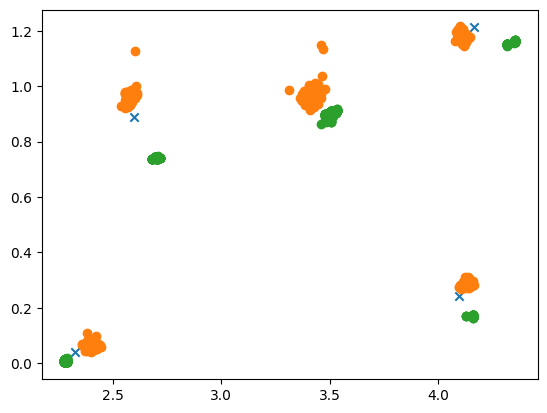

[0.97423094 1.08616205]


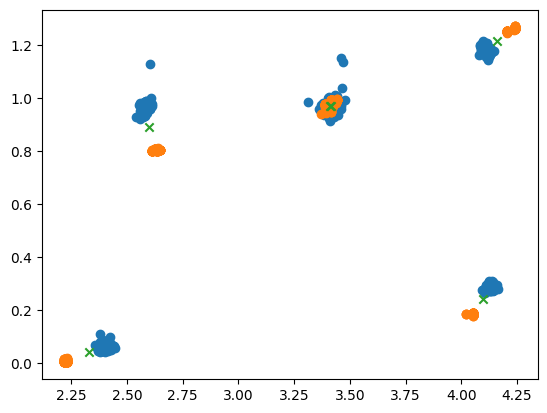

In [7]:
fig, ax = plt.subplots()
ax.scatter(positions[:,0],positions[:,1],marker='x')
ax.scatter(lidar_meas[:,0],lidar_meas[:,1])
ax.scatter(vis_meas[:,0],vis_meas[:,1])

plt.show()

# offset = result.atVector(gtsam.symbol('b',0))
slope = result.atVector(gtsam.symbol('m',0))

# print(offset)
print(slope)

lidar_meas_corrected = lidar_meas
# vis_meas_corrected = vis_meas*slope + offset
vis_meas_corrected = vis_meas*slope

fig, ax = plt.subplots()

ax.scatter(lidar_meas_corrected[:,0],lidar_meas_corrected[:,1])
ax.scatter(vis_meas_corrected[:,0],vis_meas_corrected[:,1])
ax.scatter(positions[:,0],positions[:,1],marker='x')

plt.show()

## Compute visual, lidar variance

In [8]:
zero_mean_lidar_meas = np.empty((0,2))
zero_mean_vis_meas = np.empty((0,2))

pos_idx = 0

# for grid_det_idx in [0,2,4,6,8,12,14,15,17,18]:

#     # Get position
#     pos = result.atVector(gtsam.symbol('p',pos_idx))
#     positions = np.append(positions,[pos],axis=0)

#     # Get LiDAR measurements
#     lidar_pos_meas = get_lidar_pos_measurements(f'../../bags/tracker_calibration/static_grid_dets/static_grid_dets_{grid_det_idx}.mcap')
#     zero_mean_lidar_meas_temp = lidar_pos_meas - pos
#     zero_mean_lidar_meas = np.append(zero_mean_lidar_meas,zero_mean_lidar_meas_temp,axis=0)

#     # Get visual measurements
#     visual_pos_meas = get_visual_pos_measurements(f'../../bags/tracker_calibration/static_grid_dets/static_grid_dets_{grid_det_idx}.mcap')
#     zero_mean_vis_meas_temp = visual_pos_meas*slope + offset - pos
#     zero_mean_vis_meas = np.append(zero_mean_vis_meas,zero_mean_vis_meas_temp,axis=0)
    
#     pos_idx +=1

# for det_idx in [0,2,4,5,6,8,10,13]:
#     # Get position
#     pos = result.atVector(gtsam.symbol('p',pos_idx))
#     positions = np.append(positions,[pos],axis=0)
#     # Get LiDAR measurements
#     lidar_pos_meas = get_lidar_pos_measurements(f'../../bags/tracker_calibration/static_dets/static_dets_{det_idx}.mcap')
#     zero_mean_lidar_meas_temp = lidar_pos_meas - pos
#     zero_mean_lidar_meas = np.append(zero_mean_lidar_meas,zero_mean_lidar_meas_temp,axis=0)

#     # Get visual measurements
#     visual_pos_meas = get_visual_pos_measurements(f'../../bags/tracker_calibration/static_dets/static_dets_{det_idx}.mcap')
#     zero_mean_vis_meas_temp = visual_pos_meas*slope + offset - pos
#     zero_mean_vis_meas = np.append(zero_mean_vis_meas,zero_mean_vis_meas_temp,axis=0)

#     pos_idx +=1

for det_idx in [0,2,4,6,8,9]:
    # Get position
    pos = result.atVector(gtsam.symbol('p',pos_idx))
    positions = np.append(positions,[pos],axis=0)
    # Get LiDAR measurements
    lidar_pos_meas = get_lidar_pos_measurements(f'../../bags/tracker_calibration/static_dets_a/static_dets_a_{det_idx}.mcap')
    zero_mean_lidar_meas_temp = lidar_pos_meas - pos
    zero_mean_lidar_meas = np.append(zero_mean_lidar_meas,zero_mean_lidar_meas_temp,axis=0)

    # Get visual measurements
    visual_pos_meas = get_visual_pos_measurements(f'../../bags/tracker_calibration/static_dets_a/static_dets_a_{det_idx}.mcap')
    zero_mean_vis_meas_temp = visual_pos_meas*slope - pos
    zero_mean_vis_meas = np.append(zero_mean_vis_meas,zero_mean_vis_meas_temp,axis=0)

    pos_idx +=1


print(zero_mean_lidar_meas)
print(np.sqrt(np.var(zero_mean_lidar_meas)))

print(zero_mean_vis_meas)
print(np.sqrt(np.var(zero_mean_vis_meas)))

[[ 0.06581995  0.04482135]
 [ 0.0717394   0.02046971]
 [ 0.07305691  0.02337885]
 ...
 [-0.00385396 -0.01821293]
 [-0.02377264 -0.01600345]
 [ 0.00980695 -0.00645574]]
0.04003293901636603
[[-0.09837863 -0.03341966]
 [-0.09891684 -0.03341966]
 [-0.09891684 -0.03341966]
 ...
 [ 0.00283379  0.01179686]
 [ 0.00283379  0.01179686]
 [ 0.00366385  0.01179686]]
0.0511511500463994


# Dynamic motion analysis

In [9]:
def get_pos_measurements(filepath):

    df_cols = ['stamp','sensor','det_x','det_y','corrected_x','corrected_y','det_conf']
    
    pos_df = pd.DataFrame(columns=df_cols)
    pos_array = np.empty((0,2))
    
    # If it is an mcap, examine
    if os.path.splitext(filepath)[-1] == '.mcap':

        # Create reader object           
        reader = rosbag2_py.SequentialReader()            
        reader.open(
            rosbag2_py.StorageOptions(uri=filepath, storage_id="mcap"),
            rosbag2_py.ConverterOptions(
                input_serialization_format="cdr", output_serialization_format="cdr"
            ),
        )
        topic_types = reader.get_all_topics_and_types()
        
        # Iterate through messages
        while reader.has_next():
            topic, data, timestamp = reader.read_next()
            msg_type = get_message(typename(topic,topic_types))

            if topic=='/converted_lidar_detections':
                lidar_msg = deserialize_message(data,msg_type)

                # print(lidar_msg)

                if len(lidar_msg.detections)==0:
                    pos_array = np.append(pos_array,np.empty((0,2)),axis=0)
                    temp_df = pd.DataFrame([[timestamp,'lidar',None,None,None,None,None]],columns=df_cols)
                    pos_df = pd.concat([pos_df,temp_df],ignore_index=True)
                else:
                
                    for det in lidar_msg.detections:
                        if detection_in_bounds(det, lidar_x_min, lidar_x_max, lidar_y_min, lidar_y_max):
                            det_pos = get_det_pos(det)
                            pos_array = np.append(pos_array,[det_pos[0:2]],axis=0)
                            temp_df = pd.DataFrame([[timestamp,'lidar',det_pos[0],det_pos[1],det_pos[0],det_pos[1],det.class_confidence]],columns=df_cols)
                            pos_df = pd.concat([pos_df,temp_df],ignore_index=True)
            
            if topic=='/converted_vision_detections':
                visual_msg = deserialize_message(data,msg_type)

                # print(visual_msg)
                
                # TODO - add missed det
                if len(visual_msg.detections)==0:
                    pos_array = np.append(pos_array,np.empty((0,2)),axis=0)
                    temp_df = pd.DataFrame([[timestamp,'vision',None,None,None,None,None]],columns=df_cols)
                    pos_df = pd.concat([pos_df,temp_df],ignore_index=True)
                else:           
                    for det in visual_msg.detections:
                        if detection_in_bounds(det, visual_x_min, visual_x_max, visual_y_min, visual_y_max):
                            det_pos = get_det_pos(det)
                            print(det_pos)
                            corrected_pos = det_pos[0:2]*slope + offset
                            print(corrected_pos)
                            pos_array = np.append(pos_array,[det_pos[0:2]],axis=0)
                            temp_df = pd.DataFrame([[timestamp,'vision',det_pos[0],det_pos[1],corrected_pos[0],corrected_pos[1],det.class_confidence]],columns=df_cols)
                            pos_df = pd.concat([pos_df,temp_df],ignore_index=True)

    return pos_array, pos_df

In [10]:
meas = {}
meas_df = {}

df_cols = ['stamp','sensor','det_x','det_y','corrected_x','corrected_y','det_conf']

offset = np.array([-0.31696011,  0.0429002 ])
slope = np.array([0.90053492, 1.0933026 ])

for dyn_idx in [1,2,3,4]:
    meas[dyn_idx] = np.empty((0,2))
    meas_df[dyn_idx] = pd.DataFrame(columns=df_cols)
    
    for mcap_idx in [0,1]:

        # Get position measurements
        meas_temp, meas_temp_df = get_pos_measurements(f'../../bags/tracker_calibration/dynamic_dets_{dyn_idx}/dynamic_dets_{dyn_idx}_{mcap_idx}.mcap')
        meas[dyn_idx] = np.append(meas[dyn_idx],meas_temp,axis=0)
        meas_df[dyn_idx] = pd.concat([meas_df[dyn_idx],meas_temp_df],ignore_index=True)

/tmp/ipykernel_44012/145795174.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pos_df = pd.concat([pos_df,temp_df],ignore_index=True)
/tmp/ipykernel_44012/145795174.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pos_df = pd.concat([pos_df,temp_df],ignore_index=True)


[3.02760226 0.05666129 1.0482807 ]
[2.40950145 0.10484814]
[3.01026711 0.05350396 1.04527894]
[2.39389054 0.10139621]
[3.01026711 0.05350396 1.04527894]
[2.39389054 0.10139621]
[3.01099593 0.05350396 1.04255893]
[2.39454687 0.10139621]
[3.01099593 0.05350396 1.04255893]
[2.39454687 0.10139621]
[3.00953828 0.04787196 1.04799898]
[2.3932342  0.09523874]
[3.00662295 0.03660797 1.05887917]
[2.39060884 0.08292379]
[3.02320276 0.03682984 1.06469988]
[2.40553955 0.08316636]
[3.02466926 0.03399678 1.05922681]
[2.40686018 0.08006896]
[3.03924654 0.01995237 1.07334465]
[2.41998753 0.06471418]
[3.05919894 0.01433913 1.06824506]
[2.43795537 0.05857721]
[3.06068343 0.00860348 1.06270487]
[2.4392922  0.05230641]
[3.07865047 0.00865659 1.06586967]
[2.45547214 0.05236447]
[3.07865047 0.01154212 1.06586967]
[2.45547214 0.05551922]
[3.11525863 0.01168639 1.07231809]
[2.48843907 0.05567696]
[3.13466895 0.01175989 1.07276328]
[2.50591874 0.05575732]
[3.17269019 0.03572909 1.0794227 ]
[2.5401582  0.0819629

/tmp/ipykernel_44012/3937418951.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  meas_df[dyn_idx] = pd.concat([meas_df[dyn_idx],meas_temp_df],ignore_index=True)
/tmp/ipykernel_44012/145795174.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pos_df = pd.concat([pos_df,temp_df],ignore_index=True)
/tmp/ipykernel_44012/145795174.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or a

[3.63603683 0.04776919 1.07431519]
[2.95741802 0.09512638]
[3.63515372 0.04435711 1.07761099]
[2.95662276 0.09139594]
[3.6342706  0.03753294 1.08090686]
[2.95582747 0.08393506]
[3.63338748 0.03753294 1.08420269]
[2.9550322  0.08393506]
[3.63162127 0.03412085 1.0907943 ]
[2.95344166 0.08020461]
[3.63162127 0.03753294 1.0907943 ]
[2.95344166 0.08393506]
[3.63250439 0.03412085 1.08749847]
[2.95423694 0.08020461]
[3.6342706  0.03070877 1.08090686]
[2.95582747 0.07647418]
[3.63515372 0.03070877 1.07761099]
[2.95662276 0.07647418]
[3.63515372 0.03412085 1.07761099]
[2.95662276 0.08020461]
[3.6342706  0.03412085 1.08090686]
[2.95582747 0.08020461]
[3.63515372 0.03412085 1.07761099]
[2.95662276 0.08020461]
[3.63515372 0.03753294 1.07761099]
[2.95662276 0.08393506]
[3.6342706  0.03412085 1.08090686]
[2.95582747 0.08020461]
[3.60814535 0.03726096 1.08033159]
[2.93230077 0.0836377 ]
[3.60814535 0.03726096 1.08033159]
[2.93230077 0.0836377 ]
[3.63250439 0.04094502 1.08749847]
[2.95423694 0.0876655

/tmp/ipykernel_44012/145795174.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pos_df = pd.concat([pos_df,temp_df],ignore_index=True)


[1.12024702 0.27854574 0.7521026 ]
[0.69186145 0.34743498]
[1.1567836  0.23672432 0.75461992]
[0.72476391 0.30171151]
[1.28278883 0.06400371 0.85589586]
[0.83823602 0.11287562]
[ 1.38299002 -0.05796944  0.84079423]
[ 0.9284707  -0.02047794]
[ 1.40152618 -0.06892777  0.850314  ]
[ 0.94516316 -0.03245871]
[ 1.41396266 -0.07833041  0.84420658]
[ 0.95636264 -0.04273864]
[ 1.43446476 -0.08475845  0.85029657]
[ 0.9748255  -0.04976643]
[ 1.65111283 -0.08499194  0.96793386]
[ 1.16992465 -0.05002171]
[ 1.67973451 -0.08668051  0.98072259]
[ 1.19569948 -0.05186783]
[ 1.66152503 -0.17548497  0.90959244]
[ 1.1793012  -0.14895797]
[ 1.75535675 -0.17042655  0.99695704]
[ 1.26379994 -0.14342759]
[ 1.88555867 -0.17639837  1.06982711]
[ 1.38105132 -0.14995659]
[ 1.92202758 -0.18589935  1.09581622]
[ 1.41389284 -0.16034404]
[ 1.95976796 -0.19507992  1.09589463]
[ 1.44787937 -0.17038119]
[ 2.01272044 -0.21282531  1.13567303]
[ 1.49556493 -0.18978227]
[ 2.03621496 -0.21930017  1.14104545]
[ 1.51672257 -0.1

/tmp/ipykernel_44012/3937418951.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  meas_df[dyn_idx] = pd.concat([meas_df[dyn_idx],meas_temp_df],ignore_index=True)
/tmp/ipykernel_44012/3937418951.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  meas_df[dyn_idx] = pd.concat([meas_df[dyn_idx],meas_temp_df],ignore_index=True)


[1.5348173  0.37641051 0.77193734]
[1.06519646 0.45443079]
[1.46842689 0.31251249 0.83801978]
[1.00540958 0.38457091]
[1.48376087 0.29698747 0.85498663]
[1.01921837 0.36759738]
[1.69164974 0.08386248 0.95665199]
[1.20642955 0.13458726]
[1.73792324 0.08164465 0.97382474]
[1.24810046 0.1321625 ]
[1.74094785 0.01289533 1.00633053]
[1.25082423 0.0569987 ]
[1.76716116 0.01312156 1.02067356]
[1.27443022 0.05724604]
[1.92109333 0.0036097  1.09930291]
[1.41305151 0.04684669]
[1.97754247 0.00558712 1.11681056]
[1.46388594 0.04900861]
[ 2.01554422e+00 -1.87733199e-03  1.03432184e+00]
[1.49810784 0.04084771]
[ 2.06409656 -0.00384737  1.03698974]
[1.54183092 0.03869386]
[ 2.11830718e+00 -1.98074430e-03  1.06100057e+00]
[1.59064948 0.04073465]
[ 2.28526772 -0.01929863  1.08662344]
[1.74100327 0.02180096]
[ 2.34056389 -0.02425477  1.12097958]
[1.79079941 0.01638239]
[ 2.35854571 -0.01558185  1.13716812]
[1.80699266 0.02586452]
[ 2.49178591 -0.02124798  1.1750345 ]
[1.92698011 0.01966972]
[ 2.6137164

/tmp/ipykernel_44012/145795174.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pos_df = pd.concat([pos_df,temp_df],ignore_index=True)
/tmp/ipykernel_44012/145795174.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pos_df = pd.concat([pos_df,temp_df],ignore_index=True)


[1.91328174 0.19804418 1.04648175]
[1.40601691 0.25942242]
[1.82077134 0.17275536 1.03274965]
[1.32270807 0.23177408]
[1.72917869 0.09380913 0.96326256]
[1.24022568 0.14546196]
[1.69044389 0.09007451 0.96115226]
[1.20534365 0.1413789 ]
[1.64052283 0.08567515 0.94938377]
[1.16038799 0.13656906]
[1.46634704 0.07373948 0.86045355]
[1.0035366  0.12351976]
[1.41055566 0.0755993  0.84341354]
[0.95329451 0.12555311]
[1.38490537 0.07647032 0.83364603]
[0.93019553 0.1265054 ]
[1.17283318 0.17112216 0.87159727]
[0.73921712 0.22998851]
[1.28231833 0.31572777 0.74945319]
[0.83781233 0.38808619]
[2.78957257 0.7799682  1.11589289]
[2.1951474  0.89564146]
[2.82437972 0.78883147 1.10436502]
[2.22649246 0.9053317 ]
[2.88084671 0.78177929 1.01472258]
[2.27734295 0.89762153]
[2.89571871 0.77999872 1.08313011]
[2.29073571 0.89567483]
[2.94302737 0.77724874 1.09793747]
[2.33333881 0.89266827]
[3.06365242 0.69114614 1.05162444]
[2.44196588 0.79853207]
[3.08163778 0.68675578 1.05472085]
[2.45816232 0.7937320

/tmp/ipykernel_44012/3937418951.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  meas_df[dyn_idx] = pd.concat([meas_df[dyn_idx],meas_temp_df],ignore_index=True)
/tmp/ipykernel_44012/145795174.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pos_df = pd.concat([pos_df,temp_df],ignore_index=True)


[ 1.97797197 -0.02596976  1.08589291]
[1.46427272 0.0145074 ]
[ 1.89149385 -0.08114325  1.04767671]
[ 1.38639615 -0.04581392]
[ 1.79122946 -0.09448571  1.00006214]
[ 1.29610457 -0.06040127]
[ 1.69044389 -0.08696849  0.96115226]
[ 1.20534365 -0.05218268]
[ 1.58922871 -0.08274836  0.93714251]
[ 1.11419584 -0.0475688 ]
[ 1.33635579 -0.19576189  0.82857736]
[ 0.88647494 -0.17112678]
[ 1.23387986 -0.19138186  0.86775297]
[ 0.79419179 -0.16633808]
[ 0.95687618 -0.18955246  0.72462541]
[ 0.54474031 -0.16433799]


/tmp/ipykernel_44012/145795174.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pos_df = pd.concat([pos_df,temp_df],ignore_index=True)


[1.17649163 0.1762028  0.83041243]
[0.74251168 0.23554318]
[1.29861284 0.18446165 0.80795148]
[0.8524861  0.24457261]
[1.33549646 0.20473374 0.81987036]
[0.88570108 0.26673613]
[1.39448296 0.211109   0.88996233]
[0.93882049 0.27370622]
[1.42771161 0.2861709  0.91783208]
[0.96874405 0.35577159]
[1.45305559 0.31470957 0.91005797]
[0.99156719 0.386973  ]
[1.50808778 0.36825722 0.87169341]
[1.0411256  0.44551678]
[1.5337391  0.36977836 0.9207712 ]
[1.06422551 0.44717985]
[1.57212942 0.3938747  0.965412  ]
[1.09879733 0.47352444]
[1.9357045  0.58614558 1.12866919]
[1.42620939 0.68373469]
[2.00028085 0.61885828 1.15158234]
[1.48436265 0.71949956]
[3.4548139  1.06151378 1.09272608]
[2.79422045 1.20345598]
[3.46153535 1.03554404 1.06764126]
[2.80027335 1.17506319]
[3.53628398 0.95811832 1.06264326]
[2.8675871  1.09041345]
[3.54057426 0.98795599 1.04663171]
[2.87145065 1.12303505]
[3.56306429 0.93491131 1.05662945]
[2.8917037  1.06504117]
[3.68857776 0.82756966 1.0787381 ]
[3.00473297 0.9476842

/tmp/ipykernel_44012/145795174.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pos_df = pd.concat([pos_df,temp_df],ignore_index=True)
/tmp/ipykernel_44012/145795174.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pos_df = pd.concat([pos_df,temp_df],ignore_index=True)


[3.90288834 1.16133511 1.03004719]
[3.19772713 1.3125909 ]
[1.22873351 0.31628305 0.77688718]
[0.78955732 0.38869328]
[1.20527011 0.29371107 0.7139133 ]
[0.76842771 0.36401527]
[1.28411878 0.19275331 0.89570819]
[0.8394337 0.2536379]
[1.3310774  0.18385787 0.90876683]
[0.88172157 0.24391249]
[1.43762203 0.14272453 0.93839562]
[0.97766873 0.1989413 ]
[1.37679072 0.24107005 0.8255084 ]
[0.92288801 0.30646271]
[1.471618   0.14238593 0.94584537]
[1.00828329 0.19857111]
[1.72716547 0.18152057 1.03579519]
[1.23841271 0.24135711]
[1.82522224 0.09956637 0.99188537]
[1.32671625 0.15175637]
[2.01517951 0.13111562 1.12649564]
[1.49777941 0.18624924]
[2.05387617 0.12607725 1.13845613]
[1.5326271  0.18074078]
[2.09258815 0.12322052 1.05836486]
[1.56748859 0.17761751]
[2.29287774 0.08616694 1.09741951]
[1.74785637 0.13710674]
[2.35939665 0.09260914 1.05069465]
[1.80775896 0.14415001]
[2.40770157 0.09663747 1.0386153 ]
[1.85125923 0.1485542 ]
[2.45493559 0.10311521 1.03712917]
[1.89379511 0.15563633]

/tmp/ipykernel_44012/3937418951.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  meas_df[dyn_idx] = pd.concat([meas_df[dyn_idx],meas_temp_df],ignore_index=True)
/tmp/ipykernel_44012/145795174.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pos_df = pd.concat([pos_df,temp_df],ignore_index=True)
/tmp/ipykernel_44012/145795174.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or a

[1.20473478 0.2885401  0.7159112 ]
[0.76794563 0.35836184]
[1.18151905 0.27276698 0.72246669]
[0.74703905 0.34111705]
[1.2549457  0.18918206 0.78913408]
[0.81316231 0.24973344]
[1.21645217 0.18273266 0.78406038]
[0.77849755 0.24268229]
[1.19430989 0.17266379 0.82873159]
[0.75855765 0.23167397]
[1.25177247 0.13115662 0.88467698]
[0.81030472 0.18629408]
[1.26039271 0.12789947 0.89557138]
[0.81806754 0.18273302]
[ 1.57631575e+00 -1.43832515e-03  9.32179561e-01]
[1.10256727 0.04132768]
[ 1.59860194 -0.0029216   0.93815112]
[1.12263676 0.03970601]
[1.61693870e+00 1.47928996e-03 9.43064429e-01]
[1.13914965 0.04451751]
[1.69517533e+00 1.77600495e-16 9.64027839e-01]
[1.20960447 0.0429002 ]
[1.73209076e+00 1.59541168e-03 9.73919284e-01]
[1.24284811 0.04464447]
[1.82296312e+00 1.69367983e-03 1.02456981e+00]
[1.32468184 0.0447519 ]
[ 1.88660528e+00 -1.75077026e-03  1.01350873e+00]
[1.38199383 0.04098608]
[ 1.92079609 -0.00719162  1.0728772 ]
[1.41278385 0.03503758]
[1.99259585e+00 1.86982250e-03 

## Visual sanity check

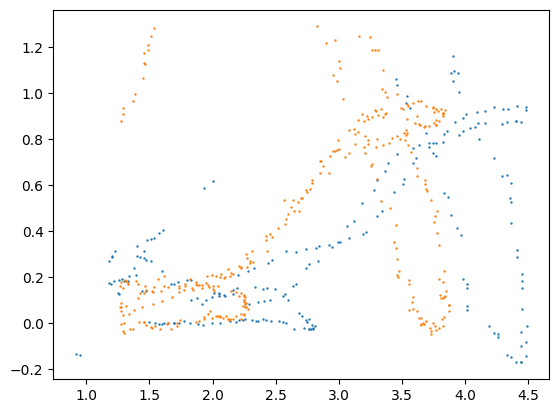

In [11]:
fig, ax = plt.subplots()

# for dyn_idx in meas.keys():
for dyn_idx in [4]:

    for sensor in ['vision','lidar']:
        
        # ax.scatter(meas[dyn_idx][:,0],meas[dyn_idx][:,1])
        df = meas_df[dyn_idx]
        data = df[df['sensor']==sensor]
        ax.scatter(data['det_x'],data['det_y'],s=0.5)

plt.show()

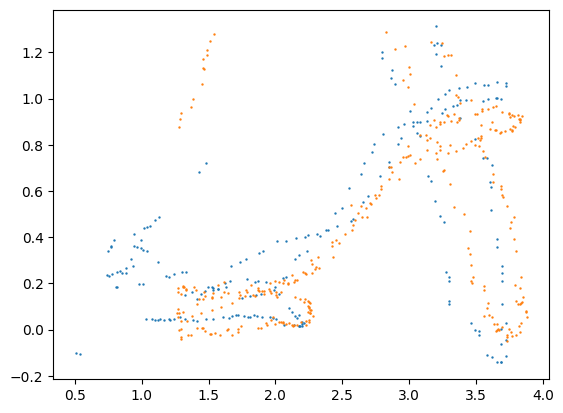

In [12]:
fig, ax = plt.subplots()

# for dyn_idx in meas.keys():
for dyn_idx in [4]:

    for sensor in ['vision','lidar']:
        
        # ax.scatter(meas[dyn_idx][:,0],meas[dyn_idx][:,1])
        df = meas_df[dyn_idx]
        data = df[df['sensor']==sensor]
        ax.scatter(data['corrected_x'],data['corrected_y'],s=0.5)

plt.show()

# Augment dataframe and iterate through with simulated tracker params

In [59]:
# Define tracker/management member functions

def create_track(conf, det_thresh):
    return conf >= det_thresh

def delete_track(track, del_thresh):
    return track.conf <= del_thresh
    
def track_active(track_x_pos, track_y_pos):
    if (track_x_pos is None) or (track_y_pos is None):
        return False
    else:
        return True

def valid_detection(det):
    if det.isnull().any():
        return False
    else:
        return True

class Track():
    # Create track from det
    def __init__(self, det_x, det_y, det_conf):
        self.x_pos = det_x
        self.y_pos = det_y
        self.x_vel = 0.
        self.y_vel = 0.
        self.conf = det_conf

    # Update track - matched det
    def update(self, det_x, det_y, det_conf):
        # TODO - kalman filter update
        self.x_pos = det_x
        self.y_pos = det_y
        self.x_vel = 0.
        self.y_vel = 0.

        # Update via parallel addition
        self.conf = 1 - ((1 - det_conf)*(1 - self.conf))/((1 - det_conf)+(1 - self.conf))
        self.conf = np.min([self.conf,.99])
    
    # Update track - missed det
    def missed_det(self, decay):
        self.conf -= decay

    # Delete track

In [57]:
# Define sensor parameters
sensor_params = {}
sensor_params['lidar'] = {}
sensor_params['lidar']['det_thresh'] = 0.85
sensor_params['lidar']['decay'] = 0.03
sensor_params['lidar']['del_thresh'] = 0.3

sensor_params['vision'] = {}
sensor_params['vision']['det_thresh'] = 0.5
sensor_params['vision']['decay'] = 0.03
sensor_params['vision']['del_thresh'] = 0.3

# Define tracker parameters
match_thresh = 0.5 # TODO

In [61]:
meas_df[4]

# Augment dataframe
for df_idx in [4]:
    full_df = meas_df[df_idx]
    full_df['track_x_pos'] = None
    full_df['track_y_pos'] = None
    full_df['track_x_vel'] = None
    full_df['track_y_vel'] = None
    full_df['track_conf'] = None

# Initialize track
track = Track(None, None, None)

# Iterate through rows
for idx in range(len(full_df)):
    print(idx)
    print(full_df.iloc[idx]['sensor'])
    print(full_df.iloc[idx]['det_conf'])

    # Check to see if track has been initiated
    if track_active(track.x_pos,track.y_pos):

        print('track is active')

        # Update with det information, if available
        if valid_detection(full_df.iloc[idx][['det_x', 'det_y', 'det_conf']]):
            print('det is valid')
            track.update(full_df.iloc[idx]['corrected_x'],full_df.iloc[idx]['corrected_y'],full_df.iloc[idx]['det_conf'])

        else:
            print('missed det')
            track.missed_det(sensor_params[full_df.iloc[idx]['sensor']]['decay'])

        print(f"Track: ({track.x_pos},{track.y_pos}) {track.conf}")
        
        full_df.at[idx,'track_x_pos'] = track.x_pos
        full_df.at[idx,'track_y_pos'] = track.y_pos
        full_df.at[idx,'track_x_vel'] = track.x_vel
        full_df.at[idx,'track_y_vel'] = track.y_vel
        full_df.at[idx,'track_conf'] = track.conf
    
        
    else:
        print('track not active')
        
        # If above threshold, create track
        if create_track(full_df.iloc[idx]['det_conf'], sensor_params[full_df.iloc[idx]['sensor']]['det_thresh']):
            print('initializing')
            track = Track(full_df.iloc[idx]['corrected_x'], full_df.iloc[idx]['corrected_y'], full_df.iloc[idx]['det_conf'])
            print(f"Track: ({track.x_pos},{track.y_pos}) {track.conf}")
            
            full_df.at[idx,'track_x_pos'] = track.x_pos
            full_df.at[idx,'track_y_pos'] = track.y_pos
            full_df.at[idx,'track_x_vel'] = track.x_vel
            full_df.at[idx,'track_y_vel'] = track.y_vel
            full_df.at[idx,'track_conf'] = track.conf
            
        # if below threshold, do nothing
    print()
full_df.to_csv('test_tracker_dev.csv')

0
vision
nan
track not active

1
vision
nan
track not active

2
vision
nan
track not active

3
vision
nan
track not active

4
vision
nan
track not active

5
vision
nan
track not active

6
vision
nan
track not active

7
vision
nan
track not active

8
vision
nan
track not active

9
vision
nan
track not active

10
vision
nan
track not active

11
vision
nan
track not active

12
vision
nan
track not active

13
vision
nan
track not active

14
vision
nan
track not active

15
vision
nan
track not active

16
vision
nan
track not active

17
vision
nan
track not active

18
vision
nan
track not active

19
vision
nan
track not active

20
vision
nan
track not active

21
vision
nan
track not active

22
vision
nan
track not active

23
vision
nan
track not active

24
vision
nan
track not active

25
vision
nan
track not active

26
vision
nan
track not active

27
vision
nan
track not active

28
vision
nan
track not active

29
vision
nan
track not active

30
vision
nan
track not active

31
vision
nan
trac

# Track confidence over time

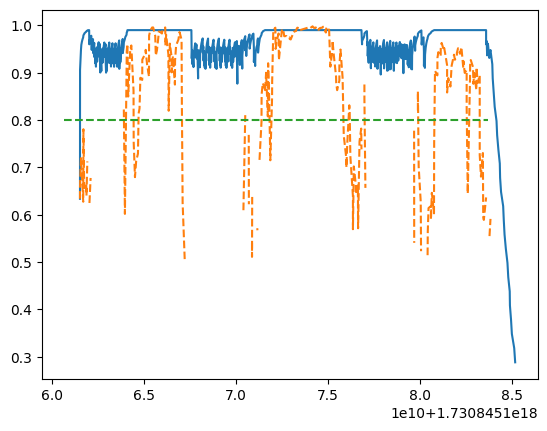

In [69]:
fig, ax = plt.subplots()

# for dyn_idx in meas.keys():
ax.plot(full_df['stamp'],full_df['track_conf'])
ax.plot(full_df[full_df['sensor']=='vision']['stamp'],full_df[full_df['sensor']=='vision']['det_conf'],linestyle='--')
ax.plot(full_df[full_df['sensor']=='lidar']['stamp'],full_df[full_df['sensor']=='lidar']['det_conf'],linestyle='--')


plt.show()